In [2]:
import os

from feature_engine.encoding import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import spacy

os.chdir("../")
from src.visualization.visualize import plot_bar_accumulated_line
os.chdir("./notebooks/")

RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'

## Taking a look at the data

For this experimentation, we will try a simple text classification. But first, we must try to understand how many classes we have and how imbalanced they are.

In [3]:
try:
    print('Using parquet file')
    df = pd.read_parquet(INTERIM_FOLDER+'complaints.pqt')
except:
    print('Using CSV file')
    df = pd.read_csv(RAW_FOLDER+'complaints.csv')
    df.to_parquet(INTERIM_FOLDER+'complaints.pqt')

print("Number of nulls per feature:")
df.isnull().sum()[df.isnull().sum()>=1].sort_values(ascending=False)

Using parquet file
Number of nulls per feature:


Tags                            2010640
Consumer disputed?              1523773
Consumer complaint narrative    1496784
Company public response         1346931
Consumer consent provided?       723261
Sub-issue                        632163
Sub-product                      235164
ZIP code                         221074
State                             37959
Company response to consumer          1
dtype: int64

In [4]:
df_cleaned = df.loc[
    ~df["Consumer complaint narrative"].isnull(), ["Date received", "Consumer complaint narrative", "Company", "Issue", "Product"]
    ]

df_cleaned.sort_values(by="Date received", ascending=False, inplace=True)

print(f"""A) Total number of observations: {len(df)}
B) Observations without NaNs: {len(df_cleaned)}
Proportion B/A: {round(100 * len(df_cleaned) / len(df))}% \n""")

df_cleaned["Date received"] = df_cleaned["Date received"].astype('datetime64[ns]').dt.date
df_cleaned.head(5)

A) Total number of observations: 2292232
B) Observations without NaNs: 795448
Proportion B/A: 35% 



,Date received,Consumer complaint narrative,Company,Issue,Product
365538,2021-09-21,Received a call on my mobile; did not answer. ...,"CITIBANK, N.A.",Managing an account,Checking or savings account
139890,2021-09-21,In XXXX and XXXX 2021 I filed a dispute with t...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o..."
295357,2021-09-21,I am a victim of identity theft. XXXX XXXX XXX...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Incorrect information on your report,"Credit reporting, credit repair services, or o..."
330659,2021-09-21,I have previously submitted several complaints...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o..."
331225,2021-09-21,I have sent numerous of letters stating facts ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",Problem with a credit reporting company's inve...,"Credit reporting, credit repair services, or o..."


In [5]:
df_cleaned.sort_values(by="Issue", inplace=True)
df_cleaned.head(10)

,Date received,Consumer complaint narrative,Company,Issue,Product
1798352,2015-09-21,Opened a credit card account in XX/XX/XXXX. In...,JPMORGAN CHASE & CO.,APR or interest rate,Credit card
1947691,2016-08-02,I have a credit card for our business with 5/3...,FIFTH THIRD FINANCIAL CORPORATION,APR or interest rate,Credit card
1850494,2015-11-04,I have been a Discover credit card member sinc...,DISCOVER BANK,APR or interest rate,Credit card
1872829,2016-05-20,XXXX/XXXX/XXXX made a purchase for {$2500.00} ...,"CITIBANK, N.A.",APR or interest rate,Credit card
1851488,2015-12-17,I have been making automated payments for seve...,"CITIBANK, N.A.",APR or interest rate,Credit card
1965147,2017-02-05,I recieved promotional checks from Chase XXXX ...,JPMORGAN CHASE & CO.,APR or interest rate,Credit card
1826904,2015-06-10,I have a Capital One Credit Card with a promot...,CAPITAL ONE FINANCIAL CORPORATION,APR or interest rate,Credit card
1934304,2015-08-21,I applied for a credit card with Wells Fargo a...,WELLS FARGO & COMPANY,APR or interest rate,Credit card
1839816,2017-01-23,This morning I receive an email notification f...,JPMORGAN CHASE & CO.,APR or interest rate,Credit card
1883782,2015-06-17,I visit a XXXX office XXXX XXXX XXXX. I was to...,SYNCHRONY FINANCIAL,APR or interest rate,Credit card


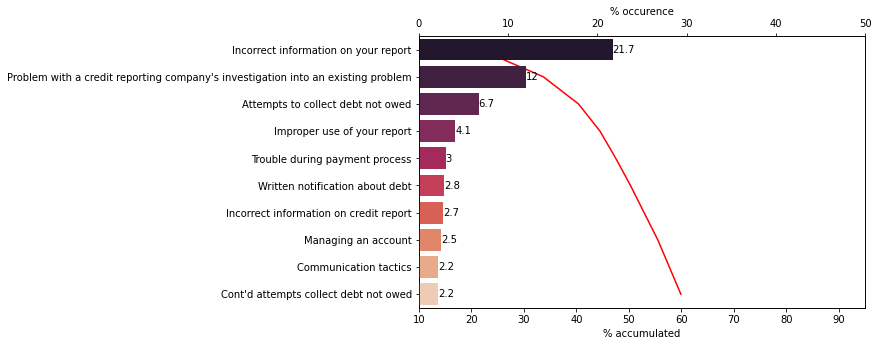

In [6]:
plot_bar_accumulated_line(df=df_cleaned, feature="Issue")

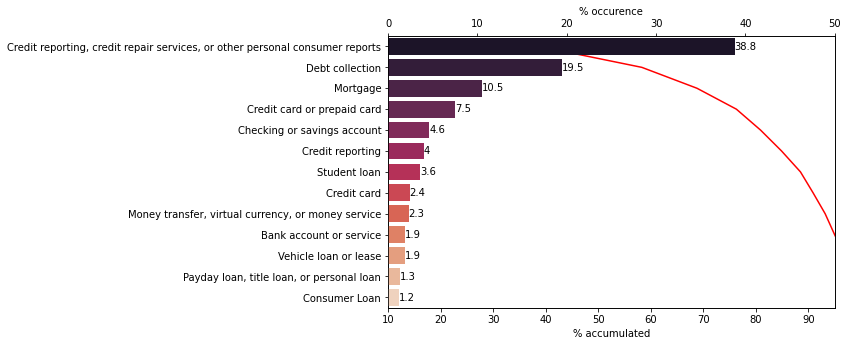

In [20]:
plot_bar_accumulated_line(df=df_cleaned, feature="Product", threshold=1)

### Comments

In this notebook, I'm still trying to narrow the problem. As we have so many imbalanced classes on **Issue** and **Product**, I will proceed with the following:

1. Create a new feature called "treated_product", because there are classes that are similar (e.g.: "Credit card" and "Credit card or prepaid card")
1. Cluster the most rare classes into a "Other products" class at **Product** feature;
1. Classify the "treated_product" using "Consumer complaint narrative" as predictor.

### 1. Create a new feature called "treated_product"

In [8]:
print(f"""There are {df_cleaned["Product"].nunique()} unique classes. And they are:""")

sorted(df_cleaned["Product"].unique().tolist())

There are 18 unique classes. And they are:


['Bank account or service',
 'Checking or savings account',
 'Consumer Loan',
 'Credit card',
 'Credit card or prepaid card',
 'Credit reporting',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan',
 'Payday loan, title loan, or personal loan',
 'Prepaid card',
 'Student loan',
 'Vehicle loan or lease',
 'Virtual currency']

As can be seen, some classes may refer to the same product. As we are trying to simplify the problem I will group similar classes together, but in real life we must be careful with this.

There are 9 unique classes. And they are:
['Bank account or service', 'Checking or savings account', 'Credit card', 'Credit reporting', 'Debt collection', 'Money transfer, virtual currency, or money service', 'Mortgage', 'Other financial service', 'Payday loan, title loan, or personal loan']


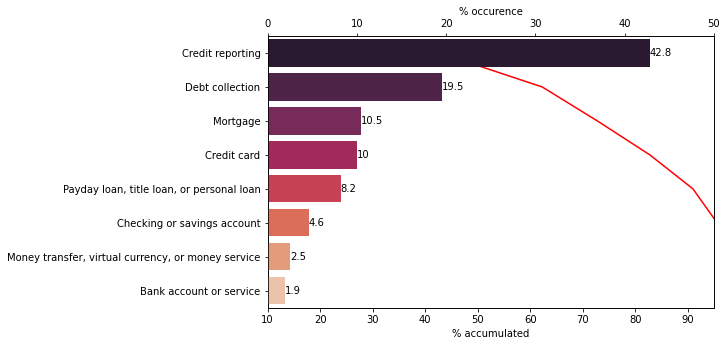

In [21]:
conditions = [
    df_cleaned["Product"]=="Credit reporting, credit repair services, or other personal consumer reports",
    df_cleaned["Product"].isin(["Credit card or prepaid card", "Prepaid card"]),
    df_cleaned["Product"].isin(["Consumer Loan", "Payday loan", "Payday loan, title loan, or personal loan", "Student loan", "Vehicle loan or lease"]),
    df_cleaned["Product"].isin(["Money transfers", "Virtual currency"])
    ]

choices = [
    "Credit reporting", "Credit card", "Payday loan, title loan, or personal loan", "Money transfer, virtual currency, or money service"
    ]

df_cleaned["Product_revised"] = np.select(conditions, choices, default=df_cleaned["Product"])

print(f"""There are {df_cleaned["Product_revised"].nunique()} unique classes. And they are:""")

print(sorted(df_cleaned["Product_revised"].unique().tolist()))

plot_bar_accumulated_line(df=df_cleaned, feature="Product_revised", threshold=1)

In [22]:
df_cleaned.to_parquet(INTERIM_FOLDER+"df_cleaned.pqt")

df_cleaned.head()

,Date received,Consumer complaint narrative,Company,Issue,Product,Product_revised
1798352,2015-09-21,Opened a credit card account in XX/XX/XXXX. In...,JPMORGAN CHASE & CO.,APR or interest rate,Credit card,Credit card
1947691,2016-08-02,I have a credit card for our business with 5/3...,FIFTH THIRD FINANCIAL CORPORATION,APR or interest rate,Credit card,Credit card
1850494,2015-11-04,I have been a Discover credit card member sinc...,DISCOVER BANK,APR or interest rate,Credit card,Credit card
1872829,2016-05-20,XXXX/XXXX/XXXX made a purchase for {$2500.00} ...,"CITIBANK, N.A.",APR or interest rate,Credit card,Credit card
1851488,2015-12-17,I have been making automated payments for seve...,"CITIBANK, N.A.",APR or interest rate,Credit card,Credit card
